In [8]:
%%capture
!pip install -r requirements.txt
#!pip install folium
import dotenv
import os
dotenv.load_dotenv('~/SageMaker/env')

scldatalake = os.environ.get("scldatalake")

from pathlib import Path
import requests
import geojson
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import argparse
import folium
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString, Polygon

def calculate_nearest(row, destination, val, col='geometry'):
    dest_unary = destination['geometry'].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = destination.loc[destination.geometry  == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

def create_gdf(df, x='lat', y='lon'):
    return gpd.GeoDataFrame(df, 
    geometry=gpd.points_from_xy(df[y], df[x]), 
             crs={'init':'EPSG:4326'})

def get_distance_duration(response):
    duration = response.json()['routes'][0]['duration']
    distance = response.json()['routes'][0]['distance']
    return {'duration': duration, 'distance': distance}


scldatalake

data = pd.read_csv(scldatalake + 'Geospatial infrastructure/Healthcare Facilities/official/JAM/raw/Public-Health-Centres-adn-Hospitals.csv')

In [9]:
os.environ.get("scldatalake")


In [2]:
data[['lon', 'lat']] = data.apply(lambda x: eval(x['GeoJSON'])['coordinates'], axis=1,  result_type="expand")
centro = data[data.Type=='Health Centre'].reset_index()
hospital = data[data.Type=='Hospital'].reset_index()

hospital = create_gdf(hospital)
health_centre = create_gdf(centro)

m = folium.Map([18.2619395,-77.2718527])
locs_hospital = zip(hospital.lat, hospital.lon)
locs_centre = zip(health_centre.lat, health_centre.lon)
for location in locs_hospital:
    folium.Marker(location=location, 
        icon=folium.Icon(color='hospital-symbol', icon='home', prefix='fa'),
                  color='red',radius=5).add_to(m)

for location in locs_centre:
    folium.CircleMarker(location=location, 
        color='blue', radius=1).add_to(m)
m

NameError: name 'data' is not defined

In [3]:
health_centre['nearest_geom'] = health_centre.apply(calculate_nearest, destination=hospital, val='geometry', axis=1)
health_centre['nearest_hospital'] = health_centre.apply(calculate_nearest, destination=hospital, val='H_Name', axis=1)
# Create LineString Geometry
health_centre['line'] = health_centre.apply(lambda row: LineString([row['geometry'], row['nearest_geom']]), axis=1)
line_gdf = health_centre[["index", "nearest_hospital", "line"]].set_geometry('line')
line_gdf.crs = crs={"init":"epsg:4326"}

m = folium.Map([18.2619395,-77.2718527],
               zoom_start = 9)
locs_hospital = zip(hospital.lat, hospital.lon)
locs_centre = zip(health_centre.lat, health_centre.lon)
for location in locs_hospital:
    folium.Marker(location=location, 
        icon=folium.Icon(color='hospital-symbol', icon='home', prefix='fa'),
                  color='red',radius=5).add_to(m)

for location in locs_centre:
    folium.CircleMarker(location=location, 
        color='blue', radius=1).add_to(m)
    
folium.GeoJson(line_gdf).add_to(m)
m

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: color argument of Icon should be one of: {'cadetblue', 'pink', 'red', 'white', 'gray', 'lightgray', 'lightred', 'lightgreen', 'darkpurple', 'beige', 'darkblue', 'darkred', 'orange', 'lightblue', 'purple', 'black', 'blue', 'darkgreen', 'green'}.


# Time - Distance / Mapbox

- duration	number	A float indicating the estimated travel time, in seconds.
- distance	number	A float indicating the distance traveled, in meters.

In [118]:
import mapbox
from mapbox import DirectionsMatrix
from mapbox import Directions

service = Directions(access_token=access_token)
health_centre[['drive_distance', 'drive_duration']] = health_centre.apply(lambda x: get_distance_duration(service.directions([x['geometry'],x['nearest_geom']],
                                                                                                                             profile='mapbox.driving')),
                                                                          axis=1,  result_type="expand")

health_centre[['Type', 'H_Name', 'nearest_hospital', 'drive_distance', 'drive_duration']]

,Type,H_Name,nearest_hospital,drive_distance,drive_duration
0,Health Centre,Aenon Town,Percy Junor,1611.099,14443.822
1,Health Centre,Alston,Percy Junor,863.285,6826.805
2,Health Centre,Brandon Hill,May Pen,3683.215,30666.275
3,Health Centre,Bryant Crescent,May Pen,549.288,2748.803
4,Health Centre,Chapleton,May Pen,1895.356,18964.969
...,...,...,...,...,...
313,Health Centre,Savanna-la-mar,Sav-La-Mar,69.451,229.621
314,Health Centre,St. Leonardo,Cornwall Regional,3794.282,32201.465
315,Health Centre,Whitehouse,Black River,1272.080,17135.143
316,Health Centre,Williamsfeild,Sav-La-Mar,1630.643,16253.702


In [119]:
health_centre.to_csv('nearest_hospital_sph.csv', index=False)

[(0.0, 54425.895)]

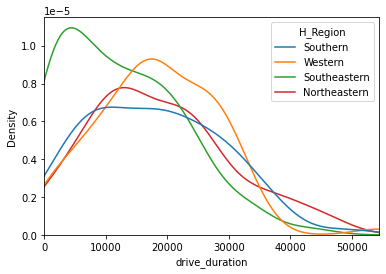

In [115]:
import seaborn as sns
max_diam = max(health_centre.drive_duration)
sns.kdeplot(data=health_centre, x="drive_duration", hue="H_Region").set(xlim=(0, max_diam))

[(0.0, 5486.419)]

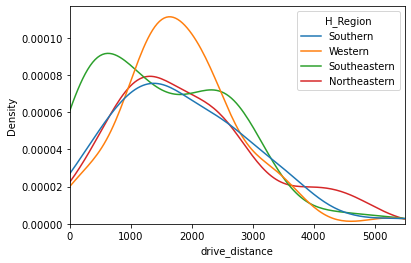

In [116]:
import seaborn as sns
max_diam = max(health_centre.drive_distance)
sns.kdeplot(data=health_centre, x="drive_distance", hue="H_Region").set(xlim=(0, max_diam))